## Init Env

In [ ]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, desc, count
from graphframes import GraphFrame

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Lab6_GraphFrames") \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.0-s_2.12") \
    .getOrCreate()


print(f"Spark Version: {spark.version}")

25/04/09 11:20:51 WARN Utils: Your hostname, ayoub-Legion-5-15ACH6H resolves to a loopback address: 127.0.1.1; using 192.168.217.25 instead (on interface wlp4s0)
25/04/09 11:20:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/ayoub/miniconda3/envs/develop/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ayoub/.ivy2/cache
The jars for the packages stored in: /home/ayoub/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8d716b6d-c752-41e3-a949-1d037aad5d3e;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.0-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
downloading https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.0-s_2.12/graphframes-0.8.2-spark3.0-s_2.12.jar ...
	[SUCCESSFUL ] graphframes#graphframes;0.8.2-spark3.0-s_2.12!graphframes.jar (814ms)
downloading https://repo1.maven.org/maven2/org/slf4j/slf4j-api/1.7.16/slf4j-api-1.7.16.jar ...
	[SUCCESSFUL ] org.slf4j#slf4j-api;1.7.16!slf4j-api.jar (367ms)
:: resolution report :: resolve 3238ms :: artifacts dl 1186ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.0-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------

Spark Version: 3.5.5


25/04/09 11:21:12 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


# Loading the Data


In [ ]:
# Load station data
station_data = spark.read.csv("../station_data.csv", header=True, inferSchema=True)

# Load trip data
trip_data = spark.read.csv("../trip_data.csv", header=True, inferSchema=True)

print("Station Data Schema:")
station_data.printSchema()
print("\nSample Station Data:")
station_data.show(5)


Station Data Schema:
root
 |-- station_id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- dockcount: integer (nullable = true)
 |-- landmark: string (nullable = true)
 |-- installation: string (nullable = true)


Sample Station Data:
+----------+--------------------+---------+-----------+---------+--------+------------+
|station_id|                name|      lat|       long|dockcount|landmark|installation|
+----------+--------------------+---------+-----------+---------+--------+------------+
|         2|San Jose Diridon ...|37.329732|-121.901782|       27|San Jose|    8/6/2013|
|         3|San Jose Civic Ce...|37.330698|-121.888979|       15|San Jose|    8/5/2013|
|         4|Santa Clara at Al...|37.333988|-121.894902|       11|San Jose|    8/6/2013|
|         5|    Adobe on Almaden|37.331415|  -121.8932|       19|San Jose|    8/5/2013|
|         6|    San Pedro Square|37.336721|-121.894074|    

In [5]:

print("\nTrip Data Schema:")
trip_data.printSchema()
print("\nSample Trip Data:")
trip_data.show(5)


Trip Data Schema:
root
 |-- Trip ID: integer (nullable = true)
 |-- Duration: integer (nullable = true)
 |-- Start Date: string (nullable = true)
 |-- Start Station: string (nullable = true)
 |-- Start Terminal: integer (nullable = true)
 |-- End Date: string (nullable = true)
 |-- End Station: string (nullable = true)
 |-- End Terminal: integer (nullable = true)
 |-- Bike #: integer (nullable = true)
 |-- Subscriber Type: string (nullable = true)
 |-- Zip Code: integer (nullable = true)


Sample Trip Data:
+-------+--------+---------------+--------------------+--------------+---------------+--------------------+------------+------+---------------+--------+
|Trip ID|Duration|     Start Date|       Start Station|Start Terminal|       End Date|         End Station|End Terminal|Bike #|Subscriber Type|Zip Code|
+-------+--------+---------------+--------------------+--------------+---------------+--------------------+------------+------+---------------+--------+
| 913460|     765|8/31/2015

In [ ]:
# Rename the 'name' column to 'id' in the stations DataFrame
vertices = station_data.withColumnRenamed("name", "id")

print("Vertices (Stations) Schema after renaming:")
vertices.printSchema()
vertices.show(5)

Vertices (Stations) Schema after renaming:
root
 |-- station_id: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- dockcount: integer (nullable = true)
 |-- landmark: string (nullable = true)
 |-- installation: string (nullable = true)

+----------+--------------------+---------+-----------+---------+--------+------------+
|station_id|                  id|      lat|       long|dockcount|landmark|installation|
+----------+--------------------+---------+-----------+---------+--------+------------+
|         2|San Jose Diridon ...|37.329732|-121.901782|       27|San Jose|    8/6/2013|
|         3|San Jose Civic Ce...|37.330698|-121.888979|       15|San Jose|    8/5/2013|
|         4|Santa Clara at Al...|37.333988|-121.894902|       11|San Jose|    8/6/2013|
|         5|    Adobe on Almaden|37.331415|  -121.8932|       19|San Jose|    8/5/2013|
|         6|    San Pedro Square|37.336721|-121.894074|      

In [ ]:
edges = trip_data.withColumnRenamed("Start Station", "src") \
                 .withColumnRenamed("End Station", "dst")

# Verify the rename operation
print("Edges (Trips) Schema after renaming:")
edges.printSchema()
edges.show(5)

Edges (Trips) Schema after renaming:
root
 |-- Trip ID: integer (nullable = true)
 |-- Duration: integer (nullable = true)
 |-- Start Date: string (nullable = true)
 |-- src: string (nullable = true)
 |-- Start Terminal: integer (nullable = true)
 |-- End Date: string (nullable = true)
 |-- dst: string (nullable = true)
 |-- End Terminal: integer (nullable = true)
 |-- Bike #: integer (nullable = true)
 |-- Subscriber Type: string (nullable = true)
 |-- Zip Code: integer (nullable = true)

+-------+--------+---------------+--------------------+--------------+---------------+--------------------+------------+------+---------------+--------+
|Trip ID|Duration|     Start Date|                 src|Start Terminal|       End Date|                 dst|End Terminal|Bike #|Subscriber Type|Zip Code|
+-------+--------+---------------+--------------------+--------------+---------------+--------------------+------------+------+---------------+--------+
| 913460|     765|8/31/2015 23:26|Harry Bridge

In [8]:
# Create the GraphFrame using vertices and edges
graph = GraphFrame(vertices, edges)

# Verify the GraphFrame creation
print("Graph Vertices Count:", graph.vertices.count())
print("Graph Edges Count:", graph.edges.count())

/home/ayoub/miniconda3/envs/develop/lib/python3.10/site-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


Graph Vertices Count: 70
Graph Edges Count: 99


## Visualization

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

def convert_to_networkx(vertices_df, edges_df, limit=100):
    """Convert GraphFrame to NetworkX graph for visualization"""
    # Convert to pandas for easier handling
    vertices_pd = vertices_df.limit(limit).toPandas()
    edges_pd = edges_df.limit(limit).toPandas()
    
    # Create NetworkX graph
    G = nx.DiGraph()
    
    # Add nodes
    for _, row in vertices_pd.iterrows():
        G.add_node(row['id'])
    
    # Add edges
    for _, row in edges_pd.iterrows():
        G.add_edge(row['src'], row['dst'])
    
    return G




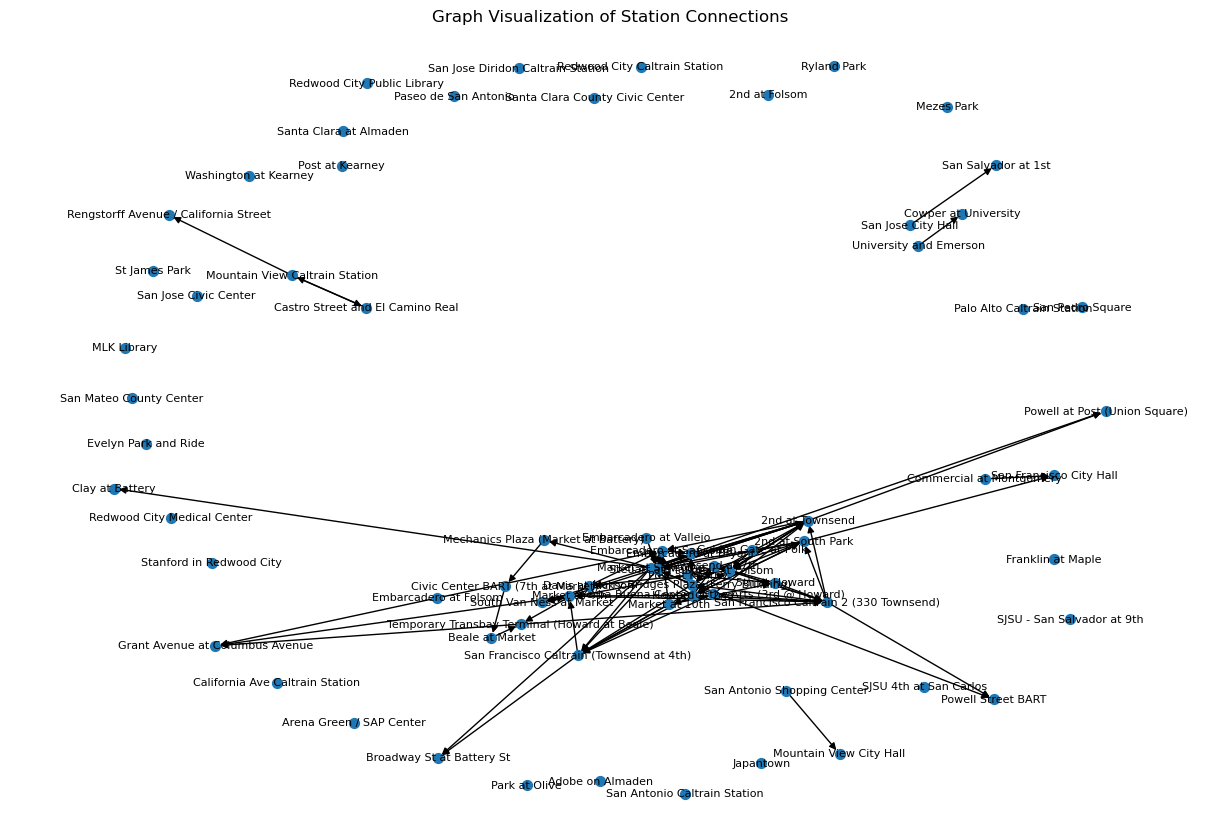

In [12]:
# Convert GraphFrame to NetworkX graph
G = convert_to_networkx(graph.vertices, graph.edges, limit=100)
# Draw the graph using NetworkX
plt.figure(figsize=(12, 8))

nx.draw(G, with_labels=True, node_size=50, font_size=8)
plt.title("Graph Visualization of Station Connections")
plt.show()

## Querying the Graph
1. Number of trips between each source and destination

In [ ]:
trips_count = graph.edges.groupBy("src", "dst") \
                         .count() \
                         .orderBy(desc("count"))

print("Number of trips between each source and destination:")
trips_count.show(10)

Number of trips between each source and destination:
+--------------------+--------------------+-----+
|                 src|                 dst|count|
+--------------------+--------------------+-----+
|San Francisco Cal...|     Townsend at 7th|    4|
|       5th at Howard|San Francisco Cal...|    3|
|San Francisco Cal...|  Powell Street BART|    2|
|     2nd at Townsend|   Market at Sansome|    2|
|     Spear at Folsom|     2nd at Townsend|    2|
|   Market at Sansome|Broadway St at Ba...|    2|
|    Davis at Jackson|Embarcadero at Sa...|    2|
|San Francisco Cal...|   2nd at South Park|    2|
|   Steuart at Market|San Francisco Cal...|    2|
|       Market at 4th|San Francisco Cal...|    2|
+--------------------+--------------------+-----+
only showing top 10 rows



1.2 Trips starting or ending at "Townsend at 7th"

In [10]:
townsend_trips = graph.edges.filter((col("src") == "Townsend at 7th") | 
                                   (col("dst") == "Townsend at 7th"))

# Group by source and destination, count trips, and sort
townsend_trips_count = townsend_trips.groupBy("src", "dst") \
                                    .count() \
                                    .orderBy(desc("count"))

print("Number of trips starting or ending at 'Townsend at 7th':")
townsend_trips_count.show(10)  

Number of trips starting or ending at 'Townsend at 7th':
+--------------------+--------------------+-----+
|                 src|                 dst|count|
+--------------------+--------------------+-----+
|San Francisco Cal...|     Townsend at 7th|    4|
|       5th at Howard|     Townsend at 7th|    1|
|     Townsend at 7th|     Spear at Folsom|    1|
|     Townsend at 7th|Harry Bridges Pla...|    1|
|     Spear at Folsom|     Townsend at 7th|    1|
|       Howard at 2nd|     Townsend at 7th|    1|
+--------------------+--------------------+-----+



1.3 Return the vertices that have never been a destination for a trip starting from "Spear at
Folsom"

In [ ]:
# all destinations from "Spear at Folsom"
destinations_from_spear = graph.edges.filter(col("src") == "Spear at Folsom").select("dst").distinct()

# we can use the lef
never_destinations = graph.vertices.select("id").subtract(destinations_from_spear.withColumnRenamed("dst", "id"))

print("Stations that have never been a destination from 'Spear at Folsom':")
never_destinations.show()

Stations that have never been a destination from 'Spear at Folsom':
+--------------------+
|                  id|
+--------------------+
|       2nd at Folsom|
|California Ave Ca...|
|Washington at Kea...|
|Powell at Post (U...|
| Golden Gate at Polk|
|Yerba Buena Cente...|
|   Market at Sansome|
|         MLK Library|
|     Spear at Folsom|
|           Japantown|
|Commercial at Mon...|
|Paseo de San Antonio|
| San Salvador at 1st|
|Rengstorff Avenue...|
|Civic Center BART...|
|         Ryland Park|
|San Jose Diridon ...|
|San Jose Civic Ce...|
|     Post at Kearney|
|          Mezes Park|
+--------------------+
only showing top 20 rows



1.4 Return the station with the maximum number of incoming trips

In [22]:
# Count incoming trips for each destination
incoming_trips = graph.edges.groupBy("dst") \
                           .count() \
                           .withColumnRenamed("dst", "station") \
                           .withColumnRenamed("count", "incoming_trips") \
                           .orderBy(desc("incoming_trips")).limit(1)
                           

print("Station with maximum number of incoming trips:")
incoming_trips.show()  

Station with maximum number of incoming trips:
+--------------------+--------------+
|             station|incoming_trips|
+--------------------+--------------+
|San Francisco Cal...|             9|
+--------------------+--------------+



15. Return the trip with the longest duration

In [ ]:
longest_trip = graph.edges.orderBy(desc("Duration")).limit(1)
print("Trip with the longest duration:")
longest_trip.show()


Trip with the longest duration:
+-------+--------+---------------+--------------------+--------------+---------------+--------------------+------------+------+---------------+--------+
|Trip ID|Duration|     Start Date|                 src|Start Terminal|       End Date|                 dst|End Terminal|Bike #|Subscriber Type|Zip Code|
+-------+--------+---------------+--------------------+--------------+---------------+--------------------+------------+------+---------------+--------+
| 913386|    1808|8/31/2015 20:23|Embarcadero at Br...|            54|8/31/2015 20:53|Harry Bridges Pla...|          50|   524|     Subscriber|   94105|
+-------+--------+---------------+--------------------+--------------+---------------+--------------------+------------+------+---------------+--------+



## Subgraphs

In [ ]:


# Alternative method (from the course slide)
townsend_subgraph_alt = GraphFrame(
    graph.vertices,
    graph.edges.filter("src = 'Townsend at 7th' OR dst = 'Townsend at 7th'")
)

print("Townsend Subgraph Details:")
print("Number of vertices:", townsend_subgraph_alt.vertices.count())
print("Number of edges:", townsend_subgraph_alt.edges.count())
townsend_subgraph_alt.edges.show(5)

Townsend Subgraph Details:
Number of vertices: 70
Number of edges: 9
+-------+--------+---------------+--------------------+--------------+---------------+--------------------+------------+------+---------------+--------+
|Trip ID|Duration|     Start Date|                 src|Start Terminal|       End Date|                 dst|End Terminal|Bike #|Subscriber Type|Zip Code|
+-------+--------+---------------+--------------------+--------------+---------------+--------------------+------------+------+---------------+--------+
| 913434|     283|8/31/2015 21:19|San Francisco Cal...|            69|8/31/2015 21:24|     Townsend at 7th|          65|   521|     Subscriber|   94107|
| 913404|     273|8/31/2015 20:39|San Francisco Cal...|            69|8/31/2015 20:44|     Townsend at 7th|          65|   287|     Subscriber|   94107|
| 913382|     645|8/31/2015 20:20|     Townsend at 7th|            65|8/31/2015 20:31|Harry Bridges Pla...|          50|   270|     Subscriber|   94945|
| 913379|    


## Motif Finding
11. Return all paths that form a "triangle" pattern between three stations.
12. Return all paths that pass through three vertices and start from "Townsend at 7th".


In [ ]:
## 11
# Define the triangle motif
triangle_motif = "(a)-[e1]->(b); (b)-[e2]->(c); (c)-[e3]->(a)"

triangles = graph.find(triangle_motif)

print("Triangle patterns between stations:")
triangles.select("a.id", "b.id", "c.id").show(5) 

Triangle patterns between stations:
+--------------------+--------------------+---------------+
|                  id|                  id|             id|
+--------------------+--------------------+---------------+
|Embarcadero at Sa...|   Steuart at Market|2nd at Townsend|
|Embarcadero at Sa...|   Market at Sansome|2nd at Townsend|
|San Francisco Cal...|     Townsend at 7th|Spear at Folsom|
|     Spear at Folsom|San Francisco Cal...|2nd at Townsend|
|     Spear at Folsom|San Francisco Cal...|Townsend at 7th|
+--------------------+--------------------+---------------+
only showing top 5 rows



In [ ]:
#12
path_motif = "(a)-[e1]->(b); (b)-[e2]->(c)"

paths = graph.find(path_motif).filter("a.id = 'Townsend at 7th'")

print("Paths through three vertices starting from 'Townsend at 7th':")
paths.select("a.id", "b.id", "c.id").show(5)  

Paths through three vertices starting from 'Townsend at 7th':
+---------------+--------------------+--------------------+
|             id|                  id|                  id|
+---------------+--------------------+--------------------+
|Townsend at 7th|Harry Bridges Pla...|     2nd at Townsend|
|Townsend at 7th|Harry Bridges Pla...|Embarcadero at Br...|
|Townsend at 7th|Harry Bridges Pla...|San Francisco Cal...|
|Townsend at 7th|     Spear at Folsom|     2nd at Townsend|
|Townsend at 7th|     Spear at Folsom|    Davis at Jackson|
+---------------+--------------------+--------------------+
only showing top 5 rows

